### BiblioPal: Keep the Community Coming to Your Library. 

**Motivation**: Libraries are crucial to communities: they provide space, programs and resources free of charge at the time of use. In fact,  annually in the United States , there are 1.4 billion visits to libraries, 113 million program attendees and 2.2 billion materials are circulated each year. Therefore, libraries must (1) promote usage of their space and (2) understand how their operational choices impact library usage. 

I define library usage as Annual Visits/Local Population (or annual visits per person). Library usage varies significantly among public libraries (see data exploration below).

**Libraires make many choices that may impact usage**: 
1. Resource choice: Collections offered, programs offered, other services (bookmobile, interlibrary loans, hours open, etc.). 
2. Staffing choices: Number of librarians employed, education level of staff.
3. Spending choices: Collections spending, staff salaries and benefits. 

But which choices actually impact usage?

BiblioPal is a tool to determine how libraries’ resources, staffing and spending choices affect library usage. 

**Business use case**: How can a library use BiblioPal?  
Use case #1: Your library has increased funding next year (congratulations!). How can you best allocate those funds to efficiently increase library usage in your community?  
  
Use case #2: Your library funding is limited next year. Where can you remove resources such that it has minimal impact on library usage?

**The data**:
The data used in this project is publicly available from the Institute of Museum and Library Services, which surveys over 9,000 public libraries in the United States annually.
I am using data from the last 7 years available (2010-2016), resulting in ~60,000 data points.

**Modeling strategy**: 
I used a random forest to predict library usage given operation (resource, spending, and staffing) choices. 

**End product**: I built BiblioPal, a tool that allows user to choose a library and see how changes to featurevalues are predicted to impact usage for this library. Although the tool is no longer hosted online, I provide code to run the site locally. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import sys
#sys.path.append('//Users/Olga/Documents/INSIGHT2019/Insight2019_LibraryProject')

In [3]:
import sqlite3

# local packages
from data import csv_to_sql_database, get_data, clean_raw_data, \
    usage_plot, usage_corr_plot, feat_corr_plot
from model import scale_features, train_test_split,  train_forest, \
    train_lr, predict_evaluate_model
from evaluation import plot_actual_v_predicted, plot_actual_v_predicted_density, \
    plot_feat_importance_lr, plot_feat_importance_forest, plot_prediction_within_error


# Get data

1. Convert library data for 2010-2016 to SQL database. 
2. Get dictionary of library dataframes with only relevant and properly normalized data.
3. Concatenate data for all 7 years.
4. Remove samples with too many (>6) null values. 
5. Impute remaining nulls with mean feature value.
6. Remove usage (label) outliers.

Note: It was not strictly necessary to convert to SQL database. Given small file size, all manipulations could have alternatively been performed in pandas.

In [5]:
con = sqlite3.connect("library_sql_db")

In [6]:
csv_to_sql_database(loc="//Users/Olga/Documents/INSIGHT2019/Library data/2010_2016_library_data", 
                    db_name="library_sql_db", 
                    con=con)          

In [7]:
library_data_dict = get_data(loc="//Users/Olga/Documents/INSIGHT2019/Library data/2010_2016_library_data", 
                             table_name_list=['library_2010',
                                            'library_2011', 
                                            'library_2012', 
                                            'library_2013', 
                                            'library_2014', 
                                            'library_2015',
                                            'library_2016'], 
                             con=con)

In [8]:
con.close()

In [9]:
library_data_clean = clean_raw_data(library_data_dict, max_null=6, std_multiplier=5)

In [10]:
print(library_data_clean.shape)

(64582, 25)


# Data exploration

Library usage for all years (2010-2016).

- **usage** = Annual library visits/Population served by library

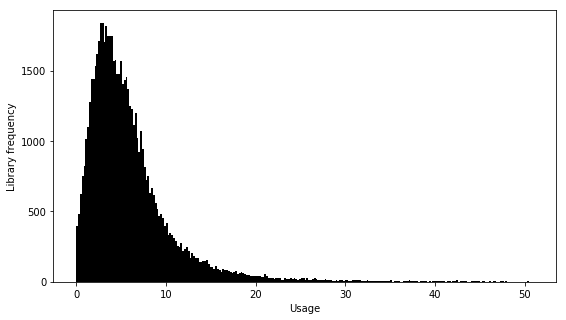

In [11]:
usage_plot(list(library_data_clean.usage), num_bins=250)

Feature correlation with label (usage)

- **Print material expenses** and **salaries** are most highly correlated with usage

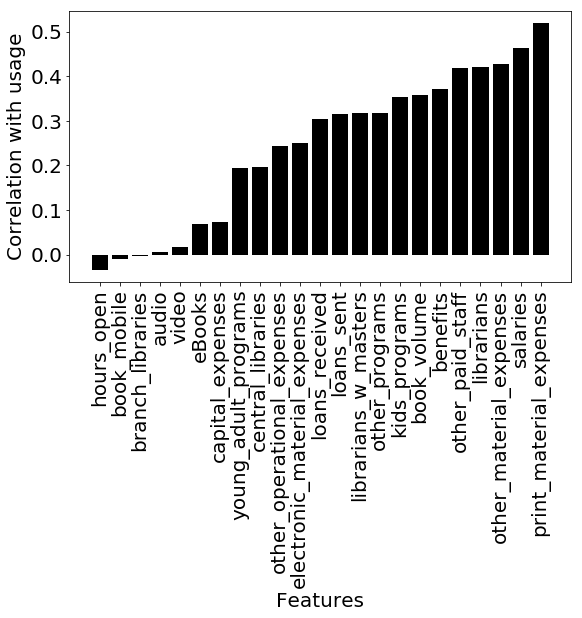

In [12]:
usage_corr_plot(library_data_clean)

Correlation between features

- It is important to know whether features are correlated because correlated features can:
    1. Make optimization algorithms for linear methods less efficient.
    2. Make it tougher to interpret feature importance.

**Results:**
- Some of the more highly correlated features make intuitive sense:
    1. Salaries correlate with benefits.
    2. Loans received correlate with loans sent.
    3. Number of central libraries correlates with book volume.

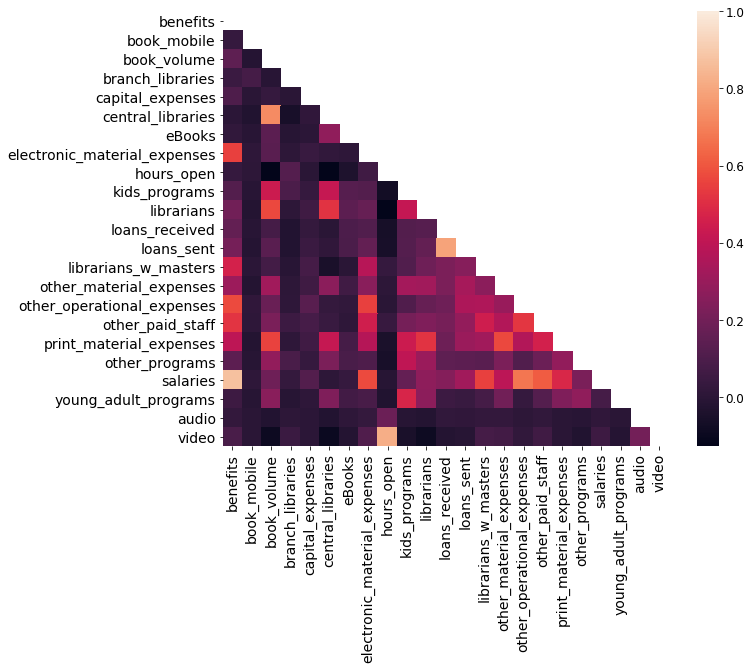

In [13]:
feat_corr_plot(library_data_clean.drop(columns = ['usage']))

For more data exploration, please see previous notebooks. Additional data exploration includes:
1. usage changes over time in signle library
2. distibution of features

# Model 1: Linear regression 

**Logic:** A linear regression is a simple prediction model whose output is very interpretable. Given appropriately scaled and uncorrelated features, the sign and weights assigned to each feature can tell you whether the feature positively or negatively contributes to the prediction and how relatively important that feature is for the prediction.

1. Split train/test: 20% of libraries in test set.
2. Scale features to range betwen 0 and 1.
    - Scaled data is important for gradient dscent optimization. We will be using **least squares** here, so it is not strictly important to scale features. 
    - Scaled features **are** required to _correctly_ determine feature importance based on coefficients. 
    - Note that I fit the scaler using _only_ train set data. This is important! It would be unfair to  fit scaler using data that includes test set data.
3. Fit linear regression on train set. 
4. Make predictions on test set. 

In [14]:
(X_train, X_test, y_train, y_test) = train_test_split(library_data_clean, seed_val=11)

In [15]:
(X_train_scaled, X_test_scaled) = scale_features(X_train, X_test)

In [16]:
lrmodel = train_lr(X_train_scaled, y_train)

In [17]:
predictions, score = predict_evaluate_model(lrmodel, X_test_scaled, y_test)

5. Evaluate predictions

In [18]:
print(f"R^2 score for Test set: {round(score,2)}")

R^2 score for Test set: 0.45


plot usage vs. predicted usage with _density of points_ overlaid. 

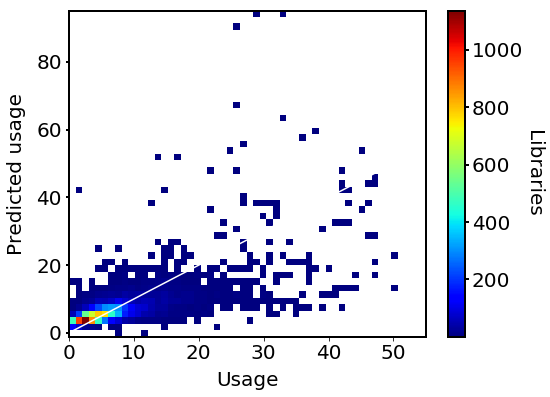

In [19]:
plot_actual_v_predicted_density(y_test, predictions, figsize=(8, 6))

**Conclusions:** Usage predictions from the linear regression model are not very good: First, linear regression does not bound prediction values to be within the range of actual values. Therefore, some predictions are simply non-sensical: usage (visitors/population served) should never be negative. Second, this model seems to under-predict usage for a lot of cases. Below, I will predict usage using a random forest which has a few advantages over the linear model: first, a random forest can learn from interactions between features. Second, a random forest bounds prediction values within the range in the train set, meaning that we will not get these non-sensical negative predictions. 

6. Get features weights

Before trying a different model, I will look at coefficients for each feature. Although the prediction output by this model is not great, it is still useful to know whether and how each feature contributes to the prediction. Because all features are scaled to a range between 0 and 1, both the sign and magnitude of each coefficient is informative. 

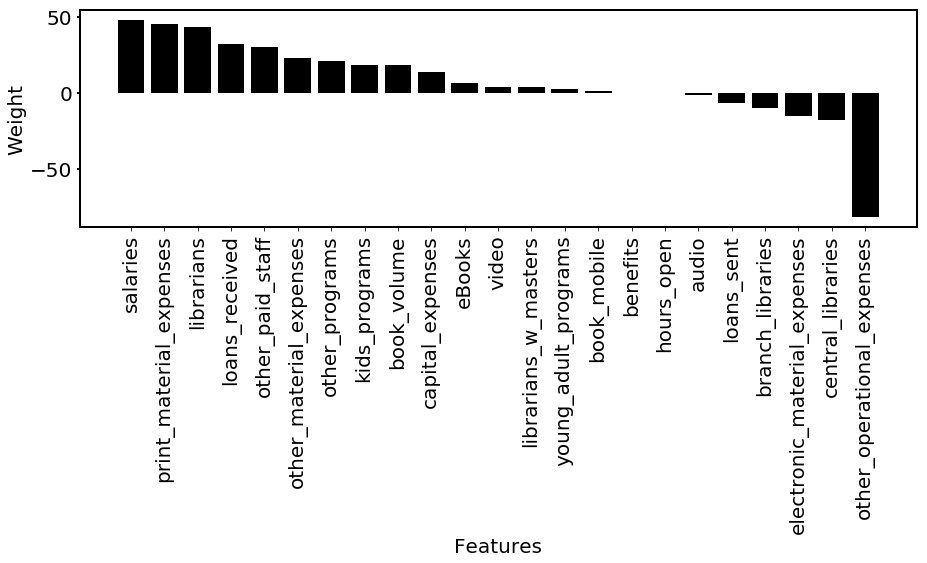

In [20]:
plot_feat_importance_lr(lrmodel, list(X_train.columns))

**Conclusions:** Salaries, librarians, and print material expenses have the most positive weights, meaning that higher values for these features would be predictive of higher library usaage. In contrast, usage predictions would decrease as other operational expenses, number of central libraries and number of branch libraries increase. Book mobile, librarians with masters, hours open and benefits do not contribute to the usage prediction.

# Model 2: Random forest

**Logic**: Unlike a linear regression, a random forest can learn from interactions betwen features. Therefore, a random forest may be better at predicting library usage than a linear model. Furthermore, unlike the linear model above, a random forest regressor model will restrict predictions to be within the range of actual values. 

1. Split train/test: 20% of libraries in test set.
2. Train random forest.
3. Make predictions on test set. 
4. Make predictions on _train set_ to see whether random forest is overfit.

In [21]:
(X_train, X_test, y_train, y_test) = train_test_split(library_data_clean, seed_val=11)

In [22]:
rfmodel = train_forest(X_train, y_train, seed_val=11)

In [24]:
predictions_test, score_test = predict_evaluate_model(rfmodel, X_test, y_test)

In [25]:
predictions_train, score_train = predict_evaluate_model(rfmodel, X_train, y_train)

5. Evaluate predictions

In [26]:
print(f"R^2 score for Test set: {round(score_test,2)}")
print(f"R^2 score for Train set: {round(score_train,2)}")

R^2 score for Test set: 0.56
R^2 score for Train set: 0.97


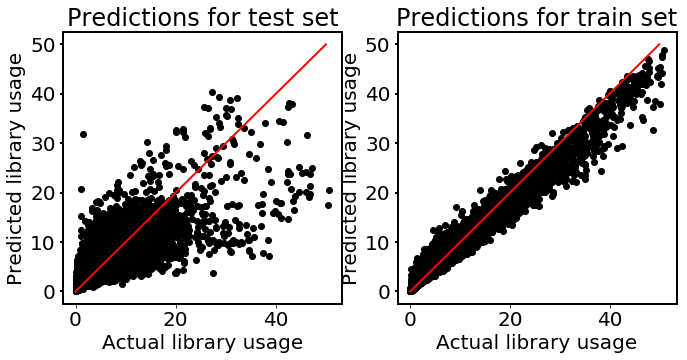

In [27]:
plot_actual_v_predicted(predictions_test, 
                       predictions_train, 
                       y_test, 
                       y_train, 
                       figsize=(11, 5))

**Conclusion #1**:

- The random forest predicts library usage better than linear regression: compare an R^2 score of .56 to .37.
- The random forest _is_ overfit:
    - Predictions made for train set have much higher R^2 than predictions made for test set.
    - Plotting actual vs. predicted values also makes it clear that forest makes poorer predictions for test set.
- This is not surprising: a random forest very often (reasonably) fits the data that it was trained on better than new data that it has never seen. 
- Overfitting can be reduced by (1) changing number of trees in forest, (2) reducing tree depth, or (3) increasing the minimum number of samples required in a leaf (which indirectly also reduces tree depth). 
- See _previous notebooks_ too see why I decide to use 100 trees and a max depth of 60 in the model.

**Next**, we will further evaluate the predictions made by the random forest on the test set.  
First, we will plot usage vs. predicted usage with _density of points_ overlaid. 

- This makes it easier to see that a high density of points lie right along the x=y line.

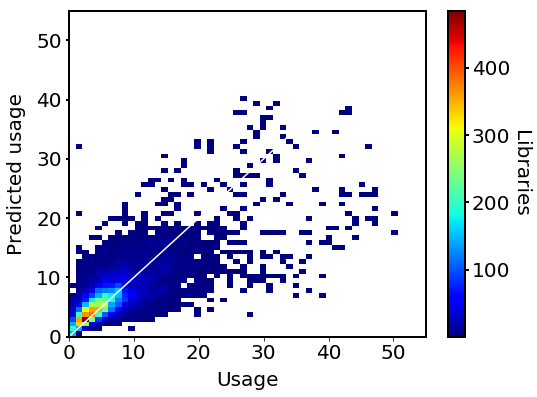

In [28]:
plot_actual_v_predicted_density(y_test, predictions_test, figsize=(8, 6))

**Conclusion #2:** Compared with the linear model above, the random forest regressor model is better at predicting library usage: the R^2 value is higher, all predicted values are within a reasonable range, and usage is under-predicted much less often.

**Next**, we will evaluate average error relative to actual usage. This metric will be easier to evaluate than the R^2 score itself: in this metric, we ask, how many librares' usage did we predict correctly within 1, 2 and 3 usage points? 

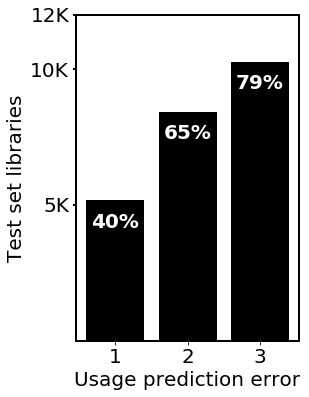

In [29]:
plot_prediction_within_error(predictions_test,y_test)

**Conclusion #3:**

We know that library usage varies from <1 to 50. Therefore, it is quite significant that we can predict usage within one usage point for 39 % of libraries and within three usage points for 78 % of libraries. 


6. Feature importance: which features are most important for predicting library usage?

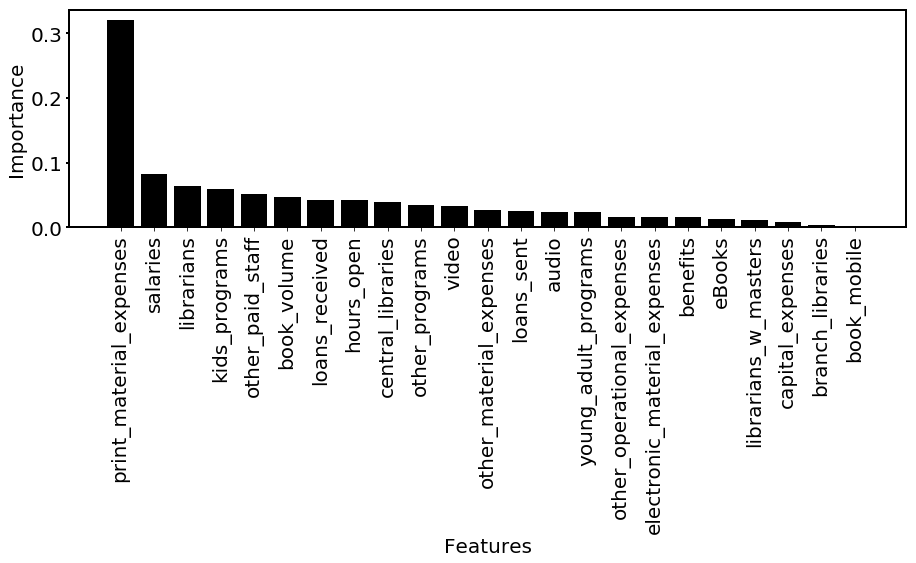

In [30]:
plot_feat_importance_forest(rfmodel, list(X_train.columns))

**Conclusions**: Print material expenses is the most predictive feature, with salaries and number of librarians following behind. This result is consistent with the linear regression model above, where these features also had the highest positive weights. Note that because this is a random forest where interactions between features are learned, we cannot determine whether these features impact usage positively or negatively. In fact, each feature could impact the usage prediction for each sample very differently, depending on the values of other features for a given sample. 